In [1]:
import janitor
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.linalg import LinAlgError

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(
    context="notebook", font_scale=1.5, style="whitegrid", palette="dark"
)  #  Darkgrid Whitegrid Dark White Ticks

from IPython.display import display
from tqdm.notebook import tqdm
# from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

installer_type_dict = {
    "pip": "human",
    "Browser": "bot",
    "bandersnatch": "bot",
    "setuptools": "human",
    "Nexus": "human",
    "requests": "bot",
    "devpi": "bot",
    "pdm": "human",
    "Homebrew": "human",
    "Artifactory": "human",
    "OS": "human",
    "Bazel": "human",
    "pex": "human",
    "conda": "human",
    "chaquopy": "human",
}

start_date = '2023-03-06'
end_date = '2023-06-04'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
assert 91 == len(date_range)

In [2]:
if False:
    # 50k pypi packages for 90 days
    download_threshold = 50
    df = (
        pd.read_csv(
            "../data/bq_50kpypi_packages_90days_20230604-052137-1685856167197.csv"
        )
        .rename_column("file_project", "pkg")
        .rename_column("timestamp_date", "date")
        .assign(date=lambda df: pd.to_datetime(df["date"]))
        # Get bot or human based on installer
        .assign(installer_type=lambda df: df["installer_name"].map(installer_type_dict))
        # Get downloads by bot vs human installations
        .pivot_table(
            index=["date", "pkg"],
            columns="installer_type",
            values="downloads",
            fill_value=0,
        )
        .astype(int)
        .reset_index()
        .sort_values(["pkg", "date"], ignore_index=True)
        # Filter to at least 50 human downloads
        .pipe(lambda df: df.query(f"pkg in @df.groupby('pkg')['human'].sum().reset_index().query('human > {download_threshold}')['pkg'].unique()"))
        # Fill in missing dates with zero
        .groupby('pkg')
        .apply(lambda x: x.set_index('date').asfreq('D').reindex(date_range))
        .remove_columns("pkg")
        .fillna(0).astype(int)
        .reset_index()
        .rename_column("level_1", "date")
    )
    print(df["date"].nunique())
    print(df["pkg"].nunique())
    # df.to_csv("../data/allpypi-dl-30days.csv", index=False)
    assert len(df)==df["date"].nunique() * df["pkg"].nunique()
    display(df)

In [3]:
if False:
    packages = df["pkg"].unique().tolist()
    results = []
    for ix, package in tqdm(enumerate(packages), total=len(packages)):
        # ====================================================================
        # Get package timeseries
        df_ = df.query(f"pkg=='{package}'").remove_columns("pkg").set_index("date")
        if len(df_) < 14:
            print("err")
            continue

        # ====================================================================
        # Estimate VAR
        maxlags = 21
        model = VAR(df_)
        var = None
        while maxlags > 0:
            try:
                var = model.fit(maxlags=maxlags, ic="aic")
                break  # Exit the loop if the model estimation succeeds
            except ValueError as e:
    #             "x contains one or more constant columns. Column(s) 9 are constant. Adding a constant with trend='c' is not allowed."
    #             "maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated."
                maxlags -= 1 
            except LinAlgError as lae:
    #             print(package)
    #             print(str(lae))
    #             print(maxlags)
                maxlags -= 1 
        if var is None:
            continue

        # ====================================================================
        # Granger test -------------------------------------------------------
        nlags = var.k_ar
        if nlags == 0:
            granger_pval_human_bot = np.nan
            granger_pval_human_human = np.nan
            granger_pval_bot_human = np.nan
            granger_pval_bot_bot = np.nan

        elif nlags > 0:
            try:
                # human -> bot
                granger_pval_human_bot = var.test_causality(
                    caused="bot", causing="human"
                ).pvalue
                # human -> human
                granger_pval_human_human = var.test_causality(
                    caused="human", causing="human"
                ).pvalue
                # bot -> human
                granger_pval_bot_human = var.test_causality(
                    caused="human", causing="bot"
                ).pvalue
                # bot -> bot
                granger_pval_bot_bot = var.test_causality(caused="bot", causing="bot").pvalue
            except LinAlgError:
                granger_pval_human_bot = np.nan
                granger_pval_human_human = np.nan
                granger_pval_bot_human = np.nan
                granger_pval_bot_bot = np.nan

        # ====================================================================
        # Check unit root ----------------------------------------------------
        # ADF
        try:
            adf_pval_human = adfuller(df_["human"], autolag="AIC")[1]
            adf_pval_bot = adfuller(df_["human"], autolag="AIC")[1]
        except OverflowError:
            adf_pval_human = np.nan
            adf_pval_bot = np.nan
        # KPSS
        try:
            kpss_pval_human = kpss(df_["bot"], regression="c")[1]
            kpss_pval_bot = kpss(df_["bot"], regression="c")[1]
        except OverflowError:
            kpss_pval_human = np.nan
            kpss_pval_bot = np.nan        


        # ====================================================================
        # White test
        if nlags > maxlags:
            # ValueError: The whiteness test can only be used when nlags is larger than the number of lags included in the model (18).
            try:
                white_pval = var.test_whiteness().pvalue
            except LinAlgError:
                white_pval = np.nan
        else:
            white_pval = np.nan

        results.append(
            [
                package,
                nlags,
                granger_pval_human_bot,
                granger_pval_human_human,
                granger_pval_bot_human,
                granger_pval_bot_bot,
                adf_pval_human,
                adf_pval_bot,
                kpss_pval_human,
                kpss_pval_bot,
                white_pval,
            ]
        )

In [4]:
if False:
    df_pkg_var_results = pd.DataFrame(
        data=results,
        columns=[
            "pkg",
            "nlags",
            "granger_pval_human_bot",
            "granger_pval_human_human",
            "granger_pval_bot_human",
            "granger_pval_bot_bot",
            "adf_pval_human",
            "adf_pval_bot",
            "kpss_pval_human",
            "kpss_pval_bot",
            "white_pval",
        ],
    )
    df_pkg_var_results.to_csv("../data/var_one_by_one_50kpypi_90days.csv", index=False)
    
df_pkg_var_results = pd.read_csv("../data/var_one_by_one_50kpypi_90days.csv")
display(df_pkg_var_results.head(3))
df_pkg_var_results.info()    

,pkg,nlags,granger_pval_human_bot,granger_pval_human_human,granger_pval_bot_human,granger_pval_bot_bot,adf_pval_human,adf_pval_bot,kpss_pval_human,kpss_pval_bot,white_pval
0,0-orchestrator,0,NaN,NaN,NaN,NaN,5.834368e-14,5.834368e-14,0.1,0.1,NaN
1,0rest,0,NaN,NaN,NaN,NaN,9.856849e-01,9.856849e-01,0.1,0.1,NaN
2,0x01-autocert-dns-aliyun,0,NaN,NaN,NaN,NaN,3.625030e-15,3.625030e-15,0.1,0.1,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13481 entries, 0 to 13480
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pkg                       13481 non-null  object 
 1   nlags                     13481 non-null  int64  
 2   granger_pval_human_bot    6620 non-null   float64
 3   granger_pval_human_human  6620 non-null   float64
 4   granger_pval_bot_human    6620 non-null   float64
 5   granger_pval_bot_bot      6620 non-null   float64
 6   adf_pval_human            13481 non-null  float64
 7   adf_pval_bot              13481 non-null  float64
 8   kpss_pval_human           13481 non-null  float64
 9   kpss_pval_bot             13481 non-null  float64
 10  white_pval                0 non-null      float64
dtypes: float64(9), int64(1), object(1)
memory usage: 1.1+ MB


In [5]:
df_pkg_var_results.filter(like="granger_pval").describe().round(3)

,granger_pval_human_bot,granger_pval_human_human,granger_pval_bot_human,granger_pval_bot_bot
count,6620.000,6620.000,6620.000,6620.000
mean,0.345,0.148,0.342,0.354
std,0.313,0.279,0.314,0.320
min,0.000,0.000,0.000,0.000
25%,0.050,0.000,0.047,0.046
50%,0.264,0.002,0.252,0.276
75%,0.603,0.116,0.601,0.621
max,1.000,1.000,1.000,1.000


In [6]:
sns.set_theme(context="notebook", font_scale=1.5, style="whitegrid")
histplot_opts = dict(color="0.1",
    stat="density",
    kde=True,
    bins=100,)
annotate_opts = dict(
    text='50th percentile',
    va="center", ha="left", 
    fontsize=18,
    arrowprops=dict(facecolor='black',)
)
vline_opts = dict(ls=(0, (5, 5)), color="navy", lw=1.2, alpha=.8)

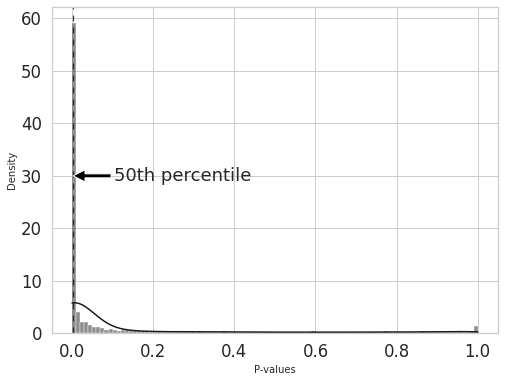

In [7]:
_, ax = plt.subplots(figsize=(8,6))

_x = "granger_pval_human_human"
sns.histplot(
    data=df_pkg_var_results, 
    x=_x, 
    ax=ax,
    **histplot_opts,
)
# Annotate median
_median = df_pkg_var_results[_x].median()
plt.axvline(_median, **vline_opts)
ax.annotate(**annotate_opts,
            xy=(_median, 30), 
            xytext=(_median+.1, 30),
           )
y_lower, y_upper = ax.get_ylim()
plt.xlabel("P-values")
savepath = "../figs/50kpypi_90days_human2human"
plt.savefig(f"{savepath}.pdf", dpi=None, bbox_inches="tight", pad_inches=0)
plt.savefig(f"{savepath}.png", dpi=120, bbox_inches="tight", pad_inches=0)

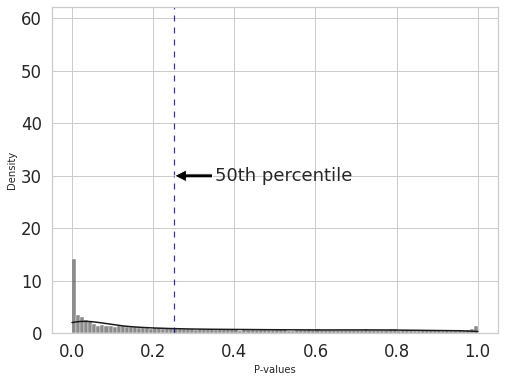

In [8]:
_, ax = plt.subplots(figsize=(8,6))

_x = "granger_pval_bot_human"
sns.histplot(
    data=df_pkg_var_results, 
    x=_x, 
    ax=ax,
    **histplot_opts,
)
# Annotate median
_median = df_pkg_var_results[_x].median()
plt.axvline(_median, **vline_opts)
ax.annotate(**annotate_opts,
            xy=(_median, 30), 
            xytext=(_median+.1, 30),
           )
ax.set_ylim(y_lower, y_upper)
plt.xlabel("P-values")
savepath = "../figs/50kpypi_90days_bot2human"
plt.savefig(f"{savepath}.pdf", dpi=None, bbox_inches="tight", pad_inches=0)
plt.savefig(f"{savepath}.png", dpi=120, bbox_inches="tight", pad_inches=0)

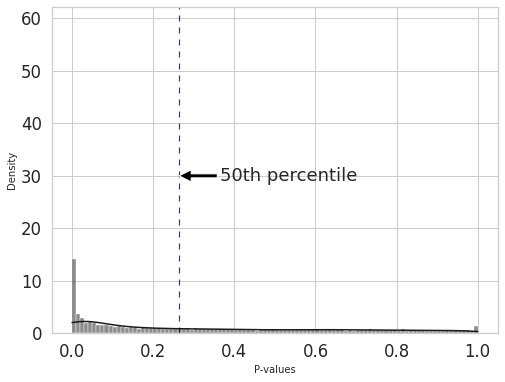

In [9]:
_, ax = plt.subplots(figsize=(8,6))

_x = "granger_pval_human_bot"
sns.histplot(
    data=df_pkg_var_results, 
    x=_x, 
    ax=ax,
    **histplot_opts,
)
# Annotate median
_median = df_pkg_var_results[_x].median()
plt.axvline(_median, **vline_opts)
ax.annotate(**annotate_opts,
            xy=(_median, 30), 
            xytext=(_median+.1, 30),
           )
ax.set_ylim(y_lower, y_upper)
plt.xlabel("P-values")
savepath = "../figs/50kpypi_90days_human2bot"
plt.savefig(f"{savepath}.pdf", dpi=None, bbox_inches="tight", pad_inches=0)
plt.savefig(f"{savepath}.png", dpi=120, bbox_inches="tight", pad_inches=0)

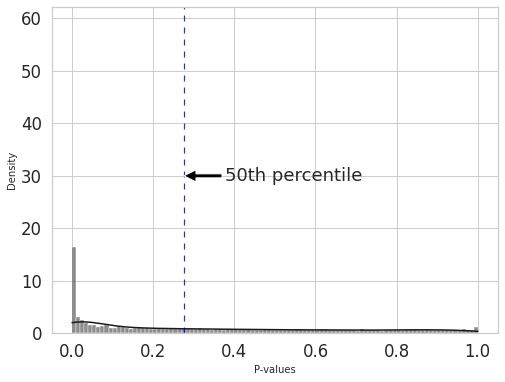

In [10]:
_, ax = plt.subplots(figsize=(8,6))

_x = "granger_pval_bot_bot"
sns.histplot(
    data=df_pkg_var_results, 
    x=_x, 
    ax=ax,
    **histplot_opts,
)
# Annotate median
_median = df_pkg_var_results[_x].median()
plt.axvline(_median, **vline_opts)
ax.annotate(**annotate_opts,
            xy=(_median, 30), 
            xytext=(_median+.1, 30),
           )
ax.set_ylim(y_lower, y_upper)
plt.xlabel("P-values")
savepath = "../figs/50kpypi_90days_bot2bot"
plt.savefig(f"{savepath}.pdf", dpi=None, bbox_inches="tight", pad_inches=0)
plt.savefig(f"{savepath}.png", dpi=120, bbox_inches="tight", pad_inches=0)